## Edge Detection Algorithms  

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from numba import jit
from scipy import signal

using_sobel = True #otherwise we will use the prewitt filter

In [24]:
@jit(nopython=True)
def slow_2d_convolution(img, kernel = None, ones = None):
    if(ones != None):
        kernel = np.ones((ones, ones)) / ones**2; 
    #convolves a 2d image with a 2d kernel, returns the modified image.
    if(kernel.shape[0] != kernel.shape[1]):
        raise ValueError("kernel must be square")
    if(kernel.shape[0] % 2 == 0):
        raise ValueError("kernel must have odd dimensions")
    #assumes kernel is normalized
    gap = kernel.shape[0] // 2; 
    conv = np.ones((img.shape[0] - 2*gap, img.shape[1] - 2*gap, img.shape[2])); 
    for i in range(conv.shape[0]):
        for j in range(conv.shape[1]):
            for k in range(conv.shape[2]):
                conv[i, j, k] = np.sum(img[i:i+gap*2+1, j:j+gap*2+1, k] * kernel);
    return conv;

def fft_convolution(img, kernel = None):
    result = np.zeros(img.shape); 
    if(len(img.shape) == 2):
        result = signal.fftconvolve(img, kernel, mode='same');
        return result; 
    for i in range(img.shape[2]):
        result[:,:,i] = signal.fftconvolve(img[:,:,i], kernel, mode='same')
    return result; 

def save_figure(img, img_name, extra = ''):
    plt.imshow(img); plt.axis('off');
    plt.savefig('Out/' + os.path.basename(img_name).split('.')[0] + extra + '.png', bbox_inches='tight', pad_inches=0, dpi= 300)
    plt.show(); 

def avg_blur(img_name, kernel_size=3):
    img = plt.imread(img_name).astype(np.float32); 
    ones = np.ones((kernel_size, kernel_size)) / kernel_size**2;
    modified_img = fft_convolution(img, kernel = ones);
    save_figure(modified_img, img_name, '_avg');

def gaussian_blur(img, kernel_size=5, std_dev = 1.0):
    kernel = np.outer(signal.windows.gaussian(kernel_size, std_dev),
                    signal.windows.gaussian(kernel_size, std_dev )); 
    kernel = kernel / np.sum(kernel);
    modified_img = fft_convolution(img, kernel = kernel);
    return modified_img;


def convert_to_grayscale(img):
    return np.dot(img[...,:3], [0.299, 0.587, 0.114])

In [52]:
# avg_blur('Images/personal/Bhavs_1.png', kernel_size=8)
img = plt.imread('Images/Chameleon_large.png').astype(np.float32); 
img = img[:,:,0:3]


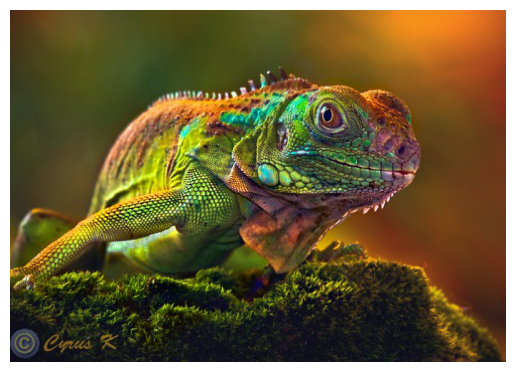

In [53]:
plt.imshow(img); plt.axis('off'); plt.show();

## Converting to Grayscale first

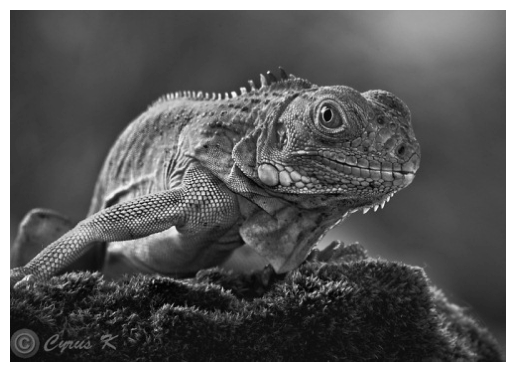

In [54]:
gray_img = convert_to_grayscale(img);
plt.imshow(gray_img, cmap='gray'); plt.axis('off'); plt.show();

## Light Gaussian smoothing

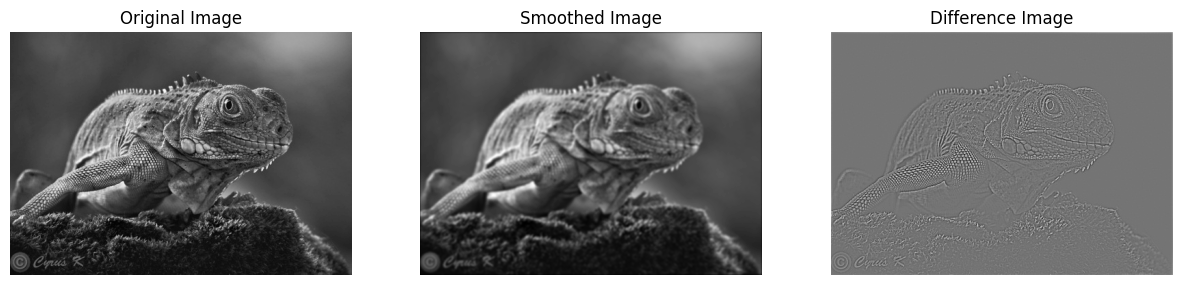

In [55]:
smoothed_img = gaussian_blur(gray_img,kernel_size=5, std_dev = 1.4)
difference = gray_img - smoothed_img;
fig,ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(gray_img, cmap='gray'); ax[0].axis('off'); ax[0].set_title('Original Image')
ax[1].imshow(smoothed_img, cmap='gray'); ax[1].axis('off'); ax[1].set_title('Smoothed Image')
ax[2].imshow(difference, cmap='gray'); ax[2].axis('off'); ax[2].set_title('Difference Image')
plt.show();

## Sobel or Prewitt Operator

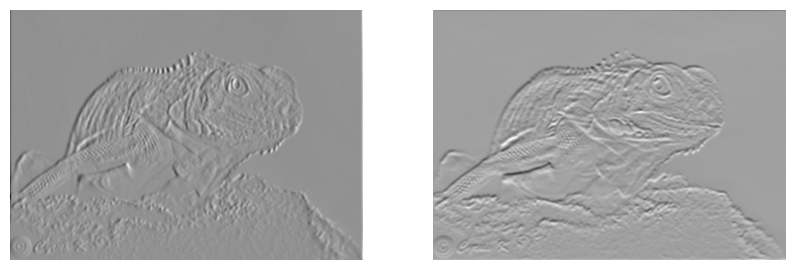

In [56]:
Ix_sobel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]);
Iy_sobel = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]);
Ix_prewitt = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]);
Iy_prewitt = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]);

Ix = fft_convolution(smoothed_img, kernel = Ix_sobel) if(using_sobel) else fft_convolution(smoothed_img, kernel = Ix_prewitt);
Iy = fft_convolution(smoothed_img, kernel = Iy_sobel) if(using_sobel) else fft_convolution(smoothed_img, kernel = Iy_prewitt);
fig,ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(Ix, cmap='gray'); ax[0].axis('off');
ax[1].imshow(Iy, cmap='gray'); ax[1].axis('off'); 
plt.show();

## Combining Ix and Iy to get the gradients

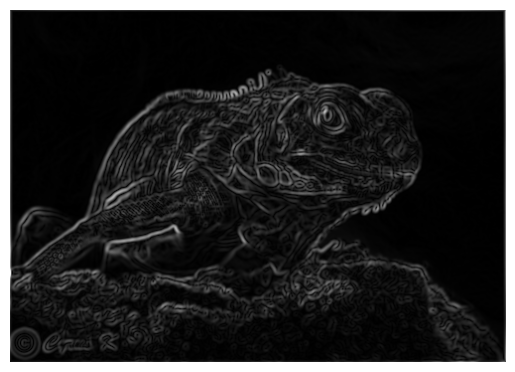

In [57]:
Igrad = np.sqrt(Ix**2 + Iy**2);
Igrad = Igrad / np.max(Igrad);
plt.imshow(Igrad, cmap='gray'); plt.axis('off'); plt.show();

## None-Maximum Suppression

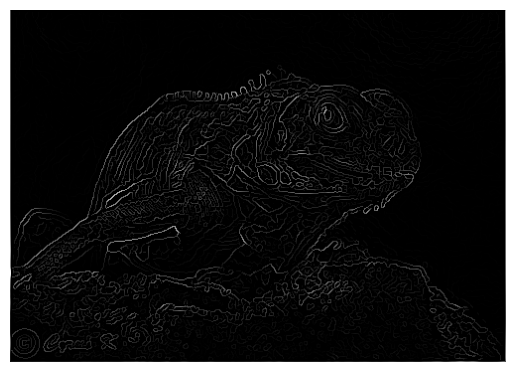

In [59]:
## We know the direction of the gradient using the formula Theta = arctan(Iy/Ix)
def none_max_suprresion(Igrad, Ix, Iy):
    #all are 2d arrays
    gap = 1;
    result = Igrad.copy();
    for i in range(gap, img.shape[0] - gap):
        for j in range(gap, img.shape[1] - gap):
            #so now we have the pixel at i,j. we need to calculate the angle of the gradient.
            angle = np.arctan(Iy[i,j] / Ix[i,j]);
            if(angle < 0):
                angle += np.pi;
            if(angle >= 0 and angle < np.pi/8):
                #check the pixel to the left and right
                if( not (Igrad[i,j] > Igrad[i,j-1] and Igrad[i,j] > Igrad[i,j+1])):
                    result[i,j] = 0;
            elif(angle >= np.pi/8 and angle < 3*np.pi/8):
                #check the pixel to the top left and bottom right
                if(not (Igrad[i,j] > Igrad[i-1,j-1] and Igrad[i,j] > Igrad[i+1,j+1])):
                    result[i,j] = 0;
            elif(angle >= 3*np.pi/8 and angle < 5*np.pi/8):
                #check the pixel to the top and bottom
                if(not(Igrad[i,j] > Igrad[i-1,j] and Igrad[i,j] > Igrad[i+1,j])):
                    result[i,j] = 0;
            elif((angle >= 5*np.pi/8 and angle < 7*np.pi/8)):
                #check the pixel to the top right and bottom left
                if not (Igrad[i,j] > Igrad[i-1,j+1] and Igrad[i,j] > Igrad[i+1,j-1]):
                    result[i,j] = 0;
            else:
                #check the pixel to the left and right
                if not (Igrad[i,j] > Igrad[i,j-1] and Igrad[i,j] > Igrad[i,j+1]):
                    result[i,j] = 0;
    return result;
nonemax_img = none_max_suprresion(Igrad, Ix, Iy);
plt.imshow(nonemax_img, cmap='gray'); plt.axis('off'); plt.show();


## Double Thresholding and edge tracking by hysteresis

Text(0.5, 1.0, 'Edge Tracking Image')

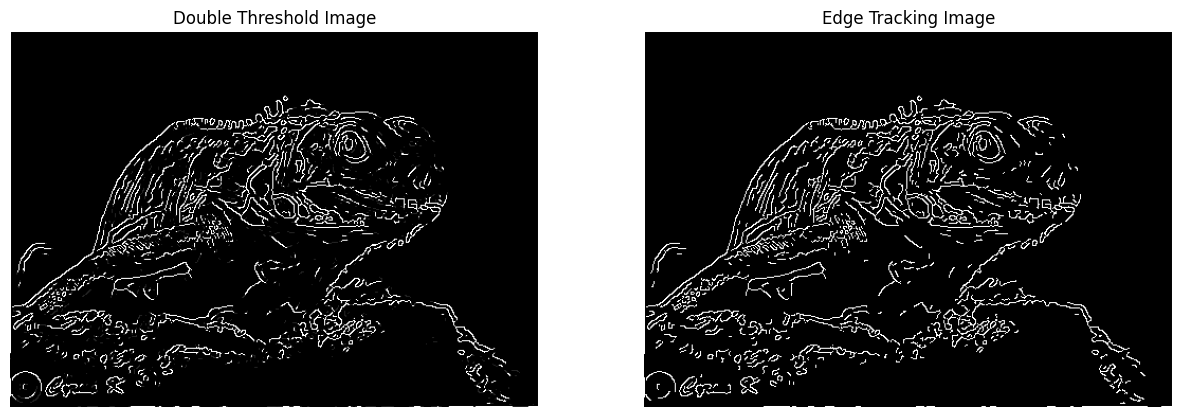

In [83]:
def double_thresholding(img, low, high):
    #low and high are percentages
    #low is the percentage of the maximum gradient magnitude
    #high is the percentage of the maximum gradient magnitude
    low = np.max(img) * low;
    high = np.max(img) * high;
    result = img.copy();
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if(img[i,j] < low):
                result[i,j] = 0;
            elif(img[i,j] > high):
                result[i,j] = 1;
            else:
                result[i,j] = img[i,j];
    return result;
low_val = 0.13;
high_val = 0.16;
double_thresh_img = double_thresholding(nonemax_img, low_val, high_val);

def edge_tracking(img, low, high):
    #low and high are actual values
    result = img.copy();
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if(img[i,j] > 0 and img[i,j] < 1):
                #check the 8 neighbors
                high_cnt = 0;
                for k in [-1,0,1]:
                    for l in [-1,0,1]:
                        if(0 <= i+k and i+k < img.shape[0] and 0 <= j + l  and j+l < img.shape[1] and img[i+k,j+l] > high):
                            high_cnt += 1;
                            break; #found atleast one neighbor that is above the high threshold
                if(high_cnt > 0):
                    result[i,j] = 1;
                else:
                    result[i,j] = 0;
    return result;

fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(double_thresh_img, cmap='gray'); ax[0].axis('off'); ax[0].set_title('Double Threshold Image')
ax[1].imshow(edge_tracking(double_thresh_img, low_val, high_val), cmap='gray'); ax[1].axis('off'); ax[1].set_title('Edge Tracking Image')